In [1]:
'''
author: Yike Xie
data: May/2023
content: kde plots for the manuscript
'''

'\nauthor: Yike Xie\ndata: 22/2/2023\ncontent: correlate image features and transcriptome\n'

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [7]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)
    
    print('filter single cells')
    adata = adata[adata.obs['doublets'] != 'Yes']

#     print('filter genes')
#     sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

def get_correlation(adata_s, feas):
    #corr = dsim.correlation.correlate_features_phenotypes(feas, fillna=0)##
    exp = adata_s.X.T
    phe = adata_s.obs[feas].fillna(0)

    x = exp #(39466, 10)
    y = phe.values.T #(2, 10)

    from scipy.stats import rankdata

    xw = np.zeros_like(x, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros_like(y, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata_s.var_names,
                    columns=phe.columns,
                    dtype=float)

    return corr

def get_correlation2(adata_s, feas):
    #corr = dsim.correlation.correlate_features_phenotypes(feas, fillna=0)##
    exp = adata_s.X.T
    phe = adata_s.obs[feas].fillna(0)

    xw = exp #(39466, 10)
    yw = phe.values.T #(2, 10)

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata_s.var_names,
                    columns=phe.columns,
                    dtype=float)

    return corr

def plot_correlation(genes, adata_s, fea, xlabel, path, filetype=False):
    '''
    genes = {
    'positive': [],
    'negative': []
    }
    '''
    import itertools
    n_genes = len(list(itertools.chain.from_iterable(genes.values())))
    colors = sns.color_palette('tab10', n_genes)
    colors = [colors[: len(genes['positive'])], colors[len(genes['positive']):]]

    fig, axs = plt.subplots(2, 1, figsize=(4, 6), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    for j, (ax, genes) in enumerate(zip(axs, [genes['positive'], genes['negative']])):
        for ig, gene in enumerate(genes):
            x = adata_s.obs[fea]
            y = adata_s[:, gene].X + 0.1
            idx = np.argsort(x)
            ax.scatter(
                x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[j][ig], s=10, 
            )
        ax.legend(fontsize=8, bbox_to_anchor=(1, 1), loc='upper left')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Gene exp [cpm]')
        ax.set_yscale('log')
#         ax.set_xscale('log')
        
    axs[0].set_title('Positive correlation')
    axs[1].set_title('Negative correlation')
    fig.tight_layout()

    if filetype is not False:
        plt.savefig(save_figures + fea + filetype)
    
    return {'fig': fig, 'axs': axs}

def plot_bins(adata, fea, bin_n, gene, cmap, filetype, path=False, rho=False, ):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = round(exp.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < exp.shape[0]]
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 3])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median() # average expression
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/(max(med) + 0.001) for i in med] # avoid average expression is 0
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, 
                  edgecolor='white', linewidth=1, size=3)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('{}:\nsmallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')
    
    if rho is not False:
        ax.text(0.5, ax.get_yticks()[-4], r'$\rho$={}'.format(round(rho, 2)))

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}

def save_PC_frac_genes(corr, PC, fea, threshold):
    res = []

    for f in corr[fea].sort_values().unique():
        df_f = corr[(corr[fea] == f)]
        hmax = df_f[PC].quantile(threshold)
        hmin = df_f[PC].quantile(1 - threshold)

        ups = df_f[df_f[PC] >= hmax].index
        downs = df_f[df_f[PC] <= hmin].index

        feas = {
            fea: f,
            'up_genes': ups, 
            'down_genes': downs, 
            'hmax': hmax, 
            'hmin': hmin,
        }
        res.append(feas)

    res = pd.DataFrame(res)
    
    return res

def plot_correlation(genes, adata, fea, xlabel, path, filetype=False):
    '''
    genes = {
    'positive': [],
    'negative': []
    }
    '''
    import itertools
    n_genes = len(list(itertools.chain.from_iterable(genes.values())))
    colors = sns.color_palette('tab10', n_genes)
    colors = [colors[: len(genes['positive'])], colors[len(genes['positive']):]]

    fig, axs = plt.subplots(2, 1, figsize=(4, 6), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    for j, (ax, genes) in enumerate(zip(axs, [genes['positive'], genes['negative']])):
        for ig, gene in enumerate(genes):
            x = adata.obs[fea]
            y = adata[:, gene].X + 0.1
            idx = np.argsort(x)
            ax.scatter(
                x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[j][ig], s=10, 
            )
        ax.legend(fontsize=8, bbox_to_anchor=(1, 1), loc='upper left')
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Gene exp [cpm]')
        ax.set_yscale('log')
#         ax.set_xscale('log')
        
    axs[0].set_title('Positive correlation')
    axs[1].set_title('Negative correlation')
    fig.tight_layout()

    if filetype is not False:
        plt.savefig(save_figures + fea + filetype)
    
    return {'fig': fig, 'axs': axs}

In [4]:
def kdes(corr, fea, path=False):
    from matplotlib.lines import Line2D
    rcParams['pdf.fonttype'] = 42

    fig, ax = plt.subplots(figsize=[3,3])
    cs = sns.color_palette('tab10', 3)

    handles = []
    labels = []
    for i, c in zip([0, 10, 50], cs):
        sns.kdeplot(data=corr[corr['Number'] > i], x=fea, lw=2, 
                    ax=ax, c=c)
        handles.append(Line2D([], [], color=c, lw=2))
        labels.append('≥{} cells'.format(str(i)))

    ax.legend(handles=handles, labels=labels, loc='upper left', 
              bbox_to_anchor=[1, 1], title='Genes expressed by')
    ax.set_xlabel(r'$\rho$ [{} vs. Exp]'.format(fea.capitalize()))
    ax.set_ylabel('Density')

    if path is not False:
        fig.savefig(path + '{}_kde_0_10_50.pdf'.format(fea), dpi=150, bbox_inches='tight')
        
def kde_fea(corr, n, fea, genes, colors, path=False):
    
    rcParams['pdf.fonttype'] = 42
    fig, ax = plt.subplots(figsize=[2.5,2.5])
    sns.kdeplot(data=corr[corr['Number'] > n], x=fea, lw=2, 
                ax=ax, c='gray')
    ax.set_title('Genes expressed by ≥{} cells'.format(str(n)))
    ax.set_xlabel(r'$\rho$ [{} vs. Exp]'.format(fea.capitalize()))
    ax.set_ylabel('Density')
    ax.grid(lw=1, ls='--', zorder=-5, alpha=0.5)

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    points = list(zip(x, y))
    t_dic = dict(points)

    x_trues = [corr.loc[gene][fea] for gene in genes]
    x_points = []
    y_points = []
    for x in x_trues:
        x_point = find_nearest(np.array(list(t_dic.keys())), x)
        x_points.append(x_point)
        y_points.append(t_dic[x_point])

    sns.scatterplot(x = x_points,
                    y = y_points, c=colors, s=50)

    for gene, x, y, c in zip(genes, x_points, y_points, colors):
        ax.annotate(gene, xy=(x, y), xytext=(x, y+0.6), arrowprops=dict(arrowstyle="<-"), 
                    va='center', ha='center', color=c)

    if path is not False:
        fig.savefig(path + '{}_kde.pdf'.format(fea), dpi=150, bbox_inches='tight')

    return {'fig': fig, 'ax': ax}

In [5]:
# load dataset
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/bkg_sub_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'
adata = sig_dataset(feas_fn, data_fn)

# add average optical intensity to adata
df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
for i in df.index:
    df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]
    
for col in df.columns:
    adata.obs['{}_{}'.format(col[0], col[1])] = df.loc[adata.obs_names][col]
    
adata.obs['C4_C2'] = df[df.columns[3]] / df[df.columns[1]]

load features
load dataset
filter single cells


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.obs` of view, copying.


Add features to adata


In [6]:
# previous code

if False:    
    feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/bkg_sub_features.pkl'
    data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'
    adata = sig_dataset(feas_fn, data_fn)
    adata.obs['spectra_norm'] = np.array(adata.obs['spectra'].tolist()).mean(axis=1) / adata.obs['area']

if False:
    # Average spectra among all channels
    adata.obs['spectra_norm'] = np.array(adata.obs['spectra'].tolist()).mean(axis=1) / adata.obs['area']
    
    print('Correlate with some simple features')
    # correlations between areas and gene expressions at single cell resolution
    feas = ['area', 'eccentricity', 'spectra_norm']
    corr = get_correlation(adata, feas)
    corr = corr.fillna(0)
    
    corr['Frac'] = 100 * (adata[:, corr.index].X > 0).sum(axis=0) / adata.obs.shape[0]
    corr['Number'] = (adata[:, corr.index].X > 0).sum(axis=0)
    corr.to_csv(save_figures + 'correlation.tsv', sep='\t')

### area, eccentricity vs gene exp

In [9]:
save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/gene/'
corr = pd.read_csv(save_figures + 'correlation.tsv', sep='\t', index_col=0)

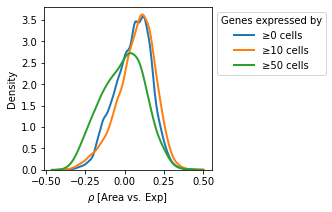

In [12]:
kdes(corr, 'area', path=save_figures)

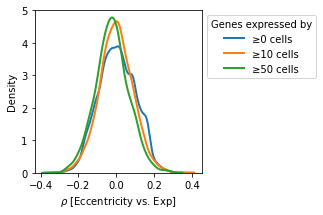

In [14]:
kdes(corr, 'eccentricity', path=save_figures)

{'fig': <Figure size 180x180 with 1 Axes>,
 'ax': <AxesSubplot: title={'center': 'Genes expressed by ≥10 cells'}, xlabel='$\\rho$ [Area vs. Exp]', ylabel='Density'>}

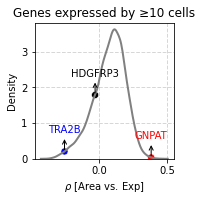

In [9]:
fea = 'area'
n = 10
genes = ['GNPAT', 'HDGFRP3', 'TRA2B']
colors = ['red', 'black', 'blue']

kde_fea(corr, n, fea, genes, colors, path=save_figures + '2')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


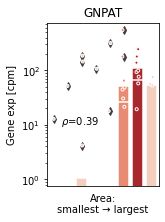

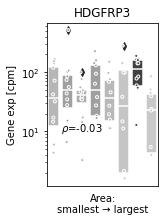

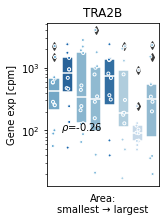

In [12]:
fea = 'area' # 'eccentricity
genes = ['GNPAT', 'HDGFRP3', 'TRA2B']
cmaps = ['Reds', 'Greys', 'Blues']
bin_n = 8

for gene, cmap in zip(genes, cmaps):
    rho = corr.loc[gene][fea]
    plot_bins(adata, fea, bin_n, gene, cmap, '_median.pdf', save_figures, rho=rho)

In [11]:
save_figures

'/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/gene/'

{'fig': <Figure size 180x180 with 1 Axes>,
 'ax': <AxesSubplot: title={'center': 'Genes expressed by ≥10 cells'}, xlabel='$\\rho$ [Eccentricity vs. Exp]', ylabel='Density'>}

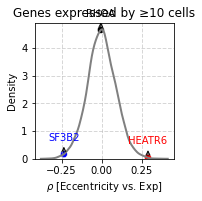

In [96]:
fea = 'eccentricity'
n = 10
genes = ['HEATR6', 'RHOA', 'SF3B2']
colors = ['red', 'black', 'blue']

kde_fea(corr, n, fea, genes, colors, path=save_figures)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


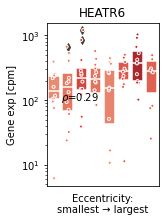

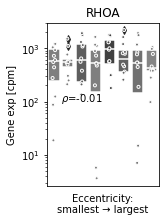

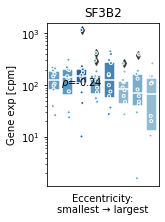

In [57]:
fea = 'eccentricity' # '
genes = ['HEATR6', 'RHOA', 'SF3B2']
cmaps = ['Reds', 'Greys', 'Blues']
bin_n = 8

for gene, cmap in zip(genes, cmaps):
    rho = corr.loc[gene][fea]
    plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', save_figures, rho)

### area va gene exp pathway analysis

In [16]:
import gseapy as gp
from gseapy.plot import barplot

def pathway_df(gene_list):    
    pthw = gp.enrichr(gene_list=gene_list,
                         gene_sets=['GO_Biological_Process_2021'],
                         description='pathway',
                         cutoff = False).res2d

    pthw_plot = pthw[:10]
    pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
    
    return pthw_plot

In [17]:
n = 150
neg_list = corr[corr['Number'] >= 10]['area'].sort_values()[:n].index.tolist()
pos_list = corr[corr['Number'] >= 10]['area'].sort_values()[-n:].index.tolist()

gene_list = neg_list + pos_list

In [18]:
pt_df_n = pathway_df(neg_list)
pt_df_p = pathway_df(pos_list)
pthw_plot = pd.concat([pt_df_p[:5], pt_df_n[:5]])

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-05-12 10:00:11,501 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = False
<ipython-input-16-b81eca27947c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.resul

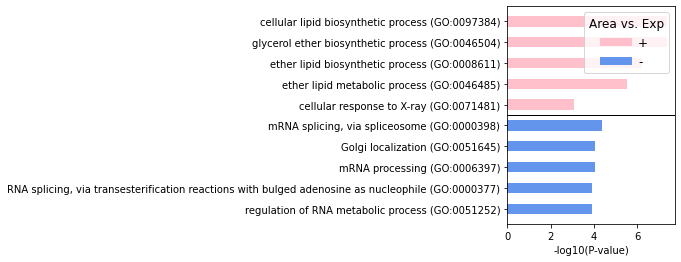

In [99]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=[3, 4])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 12

ax.barh(range(10), pthw_plot['-log10(P-value)'][::-1], height=0.5, color=['cornflowerblue'] * 5 + ['pink'] * 5)
ax.set_yticks(range(10))
ax.set_yticklabels(pthw_plot['Term'][::-1])

ax.axhline(4.5, c='k', lw=1)
handles = [Line2D([], [], lw=8, c='pink'),
           Line2D([], [], lw=8, c='cornflowerblue')]
ax.legend(handles=handles, labels=['+', '-'], title='Area vs. Exp', loc='best')

ax.set_xlabel('-log10(P-value)')
fig.savefig(save_figures + '150_genes_area_pathway2.pdf', dpi=150, bbox_inches='tight')

In [33]:
lipid_genes = pthw_plot.iloc[0].loc['Genes'].split(';')
splicing_genes = pthw_plot.iloc[5].loc['Genes'].split(';')

In [32]:
corr.loc[lipid_genes]

,area,eccentricity,Frac,Number
gene_name,,,,
GNPAT,0.385418,0.002614,28.125000,27
PEX7,0.329581,0.111131,17.708333,17
DHRS7B,0.310399,0.067421,33.333333,32
FAR1,0.311124,-0.080024,27.083333,26


In [34]:
corr.loc[splicing_genes]

,area,eccentricity,Frac,Number
gene_name,,,,
SF3B4,-0.253885,-0.029336,91.666667,88
PRMT5,-0.261774,-0.084723,68.750000,66
POLR2A,-0.259353,-0.000419,93.750000,90
PCBP1,-0.315323,-0.091035,62.500000,60
TRA2B,-0.257329,-0.074711,95.833333,92
POLR2D,-0.352117,-0.136728,65.625000,63
SNRPA,-0.236486,-0.018253,73.958333,71
U2SURP,-0.261755,0.039942,73.958333,71
CHERP,-0.268737,-0.145362,52.083333,50


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


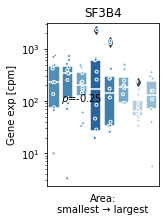

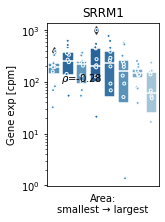

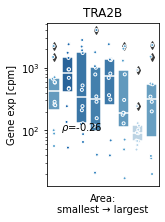

In [63]:
fea = 'area'
genes = lipid_genes + ['SF3B4', 'SRRM1', 'TRA2B']
cmaps = ['Reds',] * len(lipid_genes) + ['Blues'] * 3
bin_n = 8

for gene, cmap in zip(genes[-3:], cmaps[-3:]):
    rho = corr.loc[gene][fea]
    plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', save_figures, rho=rho)
    
genes = {
    'positive': ['GNPAT', 'PEX7', 'DHRS7B'],
    'negative': ['SF3B4', 'SRRM1', 'TRA2B']
}
fea = 'area'
xlabel = 'Area [# px]'
path = save_figures

plot_correlation(genes, adata, fea, xlabel, path, filetype='.pdf')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


{'fig': <Figure size 1200x1800 with 2 Axes>,
 'axs': array([<AxesSubplot: title={'center': 'Positive correlation'}, xlabel='Eccentricity [y/x-1]', ylabel='Gene exp [cpm]'>,
        <AxesSubplot: title={'center': 'Negative correlation'}, xlabel='Eccentricity [y/x-1]', ylabel='Gene exp [cpm]'>],
       dtype=object)}

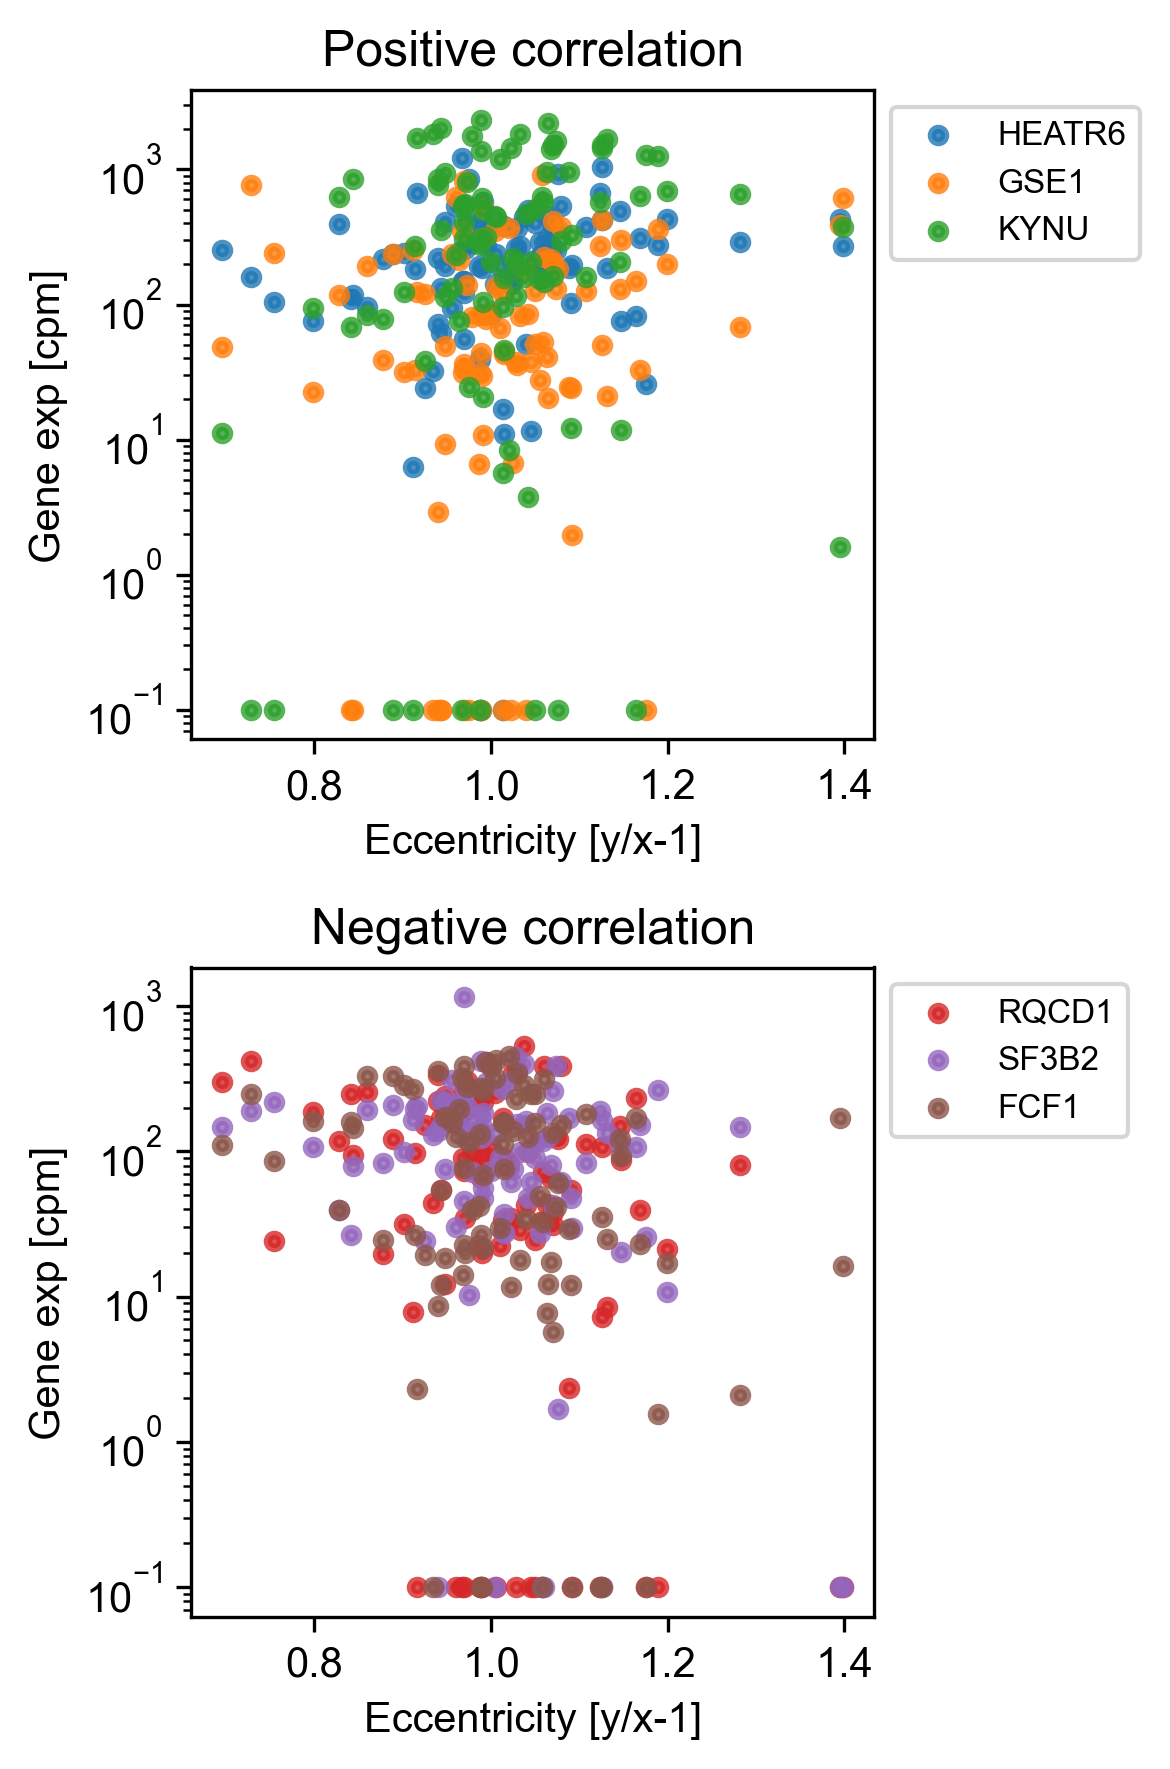

In [83]:
fea = 'eccentricity'
genes = ['HEATR6', 'GSE1', 'KYNU'] + ['RQCD1', 'SF3B2', 'FCF1']
cmaps = ['Reds'] * 3 + ['Blues'] * 3
bin_n = 8

for gene, cmap in zip(genes, cmaps):
    rho = corr.loc[gene][fea]
    plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', save_figures, rho=rho)

genes = {
    'positive': ['HEATR6', 'GSE1', 'KYNU'] ,
    'negative': ['RQCD1', 'SF3B2', 'FCF1']
}
fea = 'eccentricity'
xlabel = 'Eccentricity [y/x-1]'
path = save_figures

plot_correlation(genes, adata, fea, xlabel, path, filetype='.pdf')

In [105]:
save_figures_c = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/unmixing_gene/'
corr_channels = pd.read_csv(save_figures_c + 'correlation_abundance.tsv', sep='\t', index_col=0)

In [106]:
abundance = pd.read_csv(save_figures_c + 'NADH_abundance.tsv', sep='\t', index_col=0)
# compute the correlations between PC1, PC2 and gene expression
feas = ['Free NAD(P)H', 'Protein bound NAD(P)H']
for fea in feas:
    adata.obs[fea] = abundance.loc[adata.obs_names][fea]

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

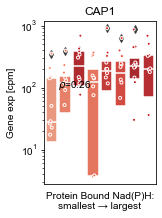

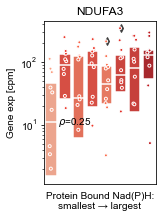

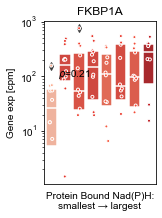

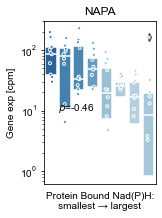

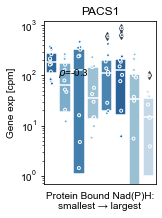

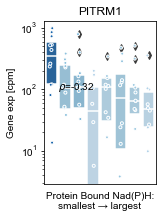

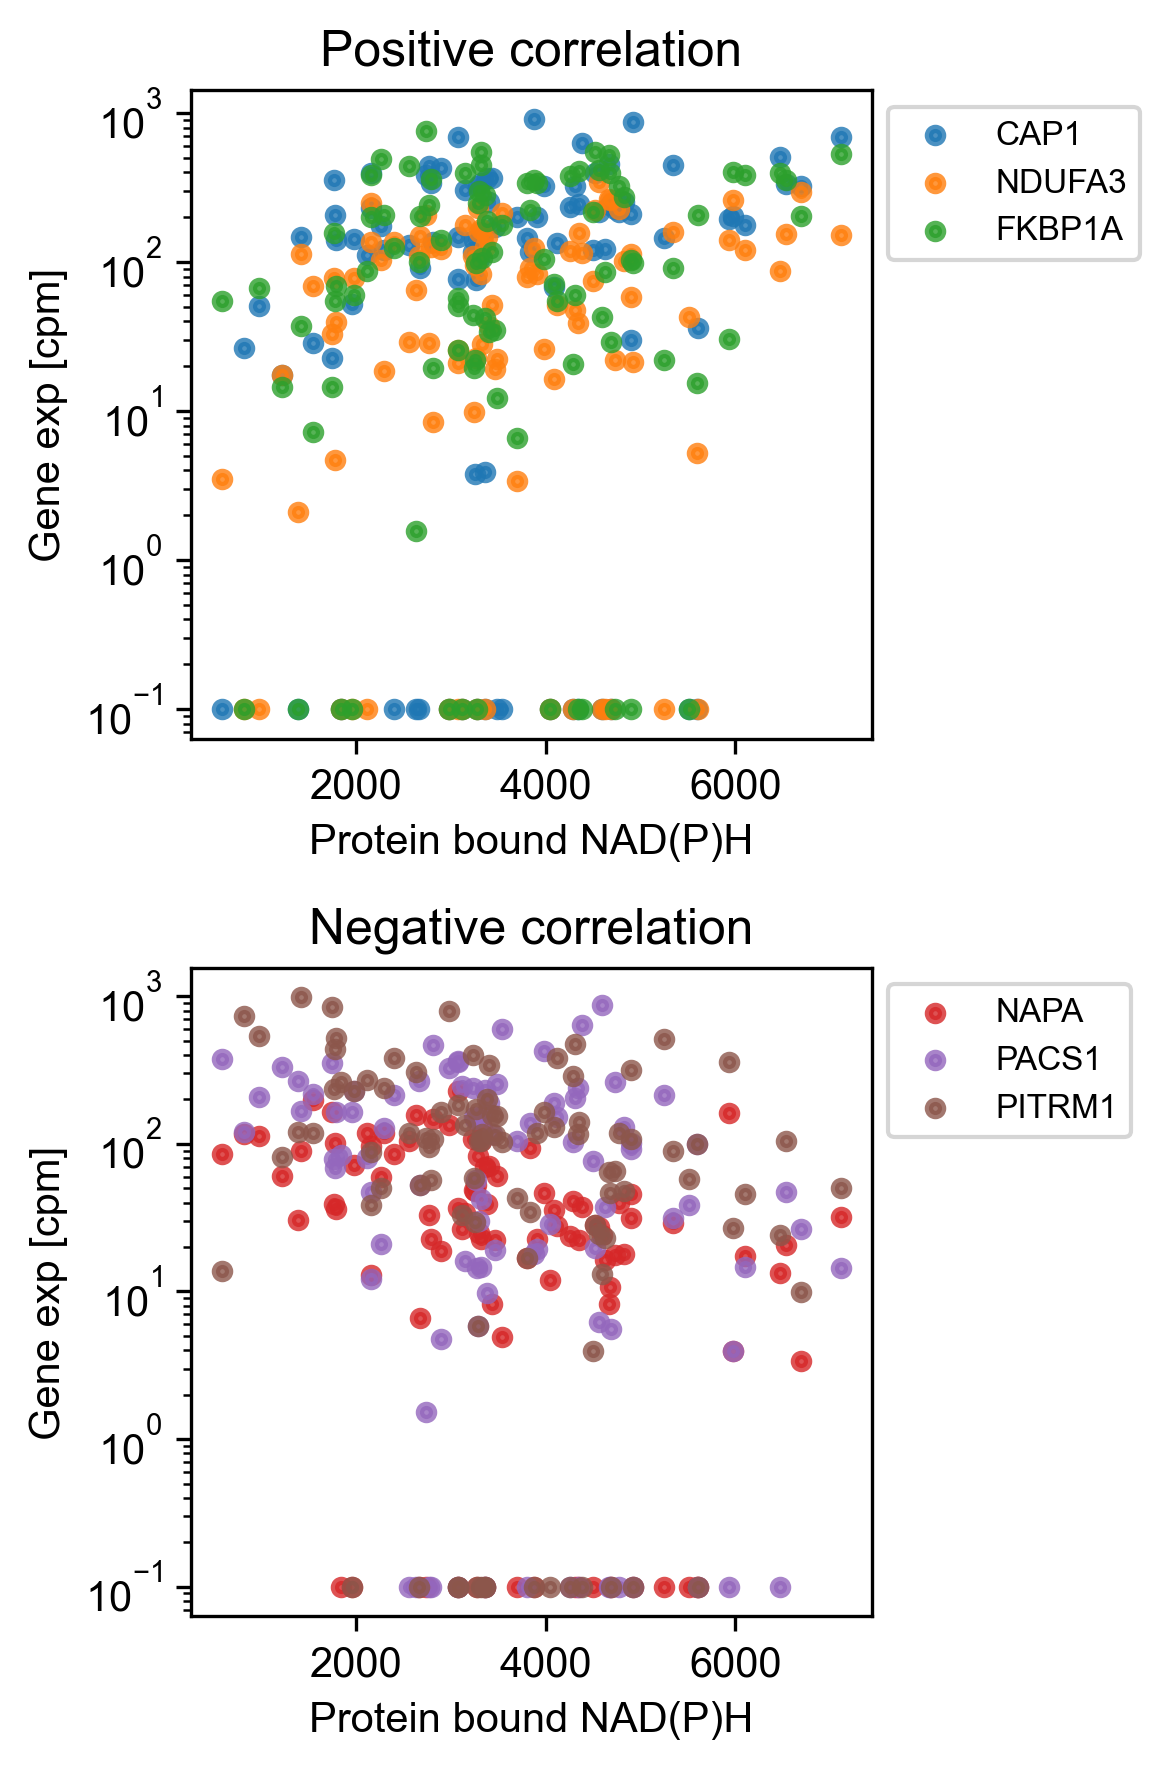

In [107]:
fea = 'Protein bound NAD(P)H'
genes = ['CAP1', 'NDUFA3', 'FKBP1A'] + ['NAPA', 'PACS1', 'PITRM1']
cmaps = ['Reds'] * 3 + ['Blues'] * 3 
bin_n = 8

for gene, cmap in zip(genes, cmaps):
    rho = corr_channels.loc[gene][fea]
    plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', save_figures_c, rho=rho)

genes = {
    'positive': ['CAP1', 'NDUFA3', 'FKBP1A'],
    'negative': ['NAPA', 'PACS1', 'PITRM1']
}
fea = 'Protein bound NAD(P)H'
xlabel = 'Protein bound NAD(P)H'
path = save_figures_c

plot_correlation(genes, adata, fea, xlabel, path, filetype='.pdf')['fig'].savefig(path + 'Protein bound NAD(P)H.pdf', dpi=150, bbox_inches='tight')

### area vs exon usage

In [13]:
def kde_fea_exon(corr, n, fea, genes, colors, path=False):
    
    rcParams['pdf.fonttype'] = 42
    fig, ax = plt.subplots(figsize=[2.5,2.5])
    sns.kdeplot(data=corr, x=fea, lw=2, 
                ax=ax, c='gray')
#     ax.set_title('Exons expressed\nby >{} cells'.format(str(n)))
    ax.set_xlabel(r'$\rho$ [{} vs. Exon usage]'.format(fea.capitalize()))
    ax.set_ylabel('Density')
    ax.grid(lw=1, ls='--', zorder=-5, alpha=0.5)

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    x = ax.lines[0].get_xdata()
    y = ax.lines[0].get_ydata()
    points = list(zip(x, y))
    t_dic = dict(points)

    x_trues = [corr.loc[gene][fea] for gene in genes]
    x_points = []
    y_points = []
    for x in x_trues:
        x_point = find_nearest(np.array(list(t_dic.keys())), x)
        x_points.append(x_point)
        y_points.append(t_dic[x_point])

    sns.scatterplot(x = x_points,
                    y = y_points, c=colors, s=50)

    for gene, x, y, c in zip(genes, x_points, y_points, colors):
        ax.annotate(str(gene).replace("'", ''), xy=(x, y), xytext=(x, y+0.5), arrowprops=dict(arrowstyle="<-"), 
                    va='center', ha='center', color=c)

    if path is not False:
        fig.savefig(path + '{}_kde_exon.pdf'.format(fea), dpi=150, bbox_inches='tight')

    return {'fig': fig, 'ax': ax}

In [14]:
save_figures2 = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/exon/'
corr_exon = pd.read_csv(save_figures2 + 'corr_area_exon_usage_omit_na_exp10.tsv', 
                        sep='\t', index_col=['gene_name', 'exon_number'])

In [15]:
# filter genes expressed by at least 10 cells
idx = corr_exon[corr_exon['n_cell_gene'] >= 10].index
idx = [gene for gene in idx if corr_exon.loc[gene[0]].shape[0] != 1]
corr_exon_show = corr_exon.loc[list(idx)]

{'fig': <Figure size 180x180 with 1 Axes>,
 'ax': <AxesSubplot: xlabel='$\\rho$ [Area vs. Exon usage]', ylabel='Density'>}

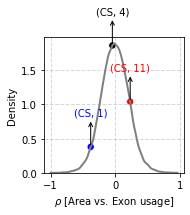

In [16]:
fea = 'area'
genes = [('CS', 11), ('CS', 4), ('CS', 1)]
colors = ['red', 'black', 'blue']

kde_fea_exon(corr_exon_show, 10, fea, genes, colors, path=save_figures2 + 'exp_10')

In [17]:
fea = 'area'
exon_rhos = {}
gene_idx = np.unique([i[0] for i in idx])

for i in gene_idx:
    maxi = corr_exon_show.loc[i][fea].max()
    mini = corr_exon_show.loc[i][fea].min()
    exon_rhos[i] = (maxi, mini)
    
exon_rhos = pd.DataFrame(exon_rhos, index=['max', 'min']).T

exon_rhos['r'] = np.sqrt(exon_rhos['max'] ** 2 + exon_rhos['min'] ** 2)

In [25]:
n_cell_gene = corr_exon.reset_index()[['gene_name', 'n_cell_gene']][~ corr_exon.reset_index()[['gene_name', 'n_cell_gene']].duplicated()]
exon_rhos['n_cell_gene'] = n_cell_gene.set_index('gene_name').loc[exon_rhos.index]

In [45]:
exon_rhos.sort_values('r', ascending=False)[:20]

,max,min,r,n_cell_gene
LINC01522,0.806644,-0.846926,1.169597,10
SGPP1,0.808146,-0.814411,1.147330,13
SLC37A4,0.827283,-0.793382,1.146234,14
ZC3HC1,0.831351,-0.782143,1.141443,15
C14orf132,0.806249,-0.806249,1.140209,10
RBKS,0.736364,-0.863636,1.134945,11
THAP7-AS1,0.795205,-0.808135,1.133770,10
GPLD1,0.792844,-0.778195,1.110941,14
NUP43,0.757663,-0.810997,1.109851,12
C19orf81,0.815492,-0.749475,1.107583,11


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'ls', 'lw'
  cset = contour_func(


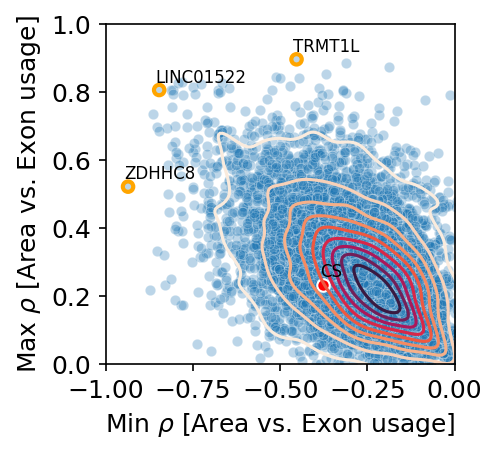

In [61]:
rcParams['pdf.fonttype'] = 42
color = sns.color_palette('tab10')
fig, ax = plt.subplots(figsize=[3, 3], dpi=150)

# label_genes = exon_rhos.sort_values('r', ascending=False)[:5].index.tolist()
label_genes = ['LINC01522', 'ZDHHC8', 'TRMT1L']

# non labeled scatters
sns.scatterplot(data=exon_rhos, x='min', y='max', ax=ax, 
                alpha=0.3, color=color[0], edgecolor='white', s=25)
# kde
sns.kdeplot(data=exon_rhos, x='min', y='max', ax=ax, ls='--', cmap='rocket_r', lw=1)
# gene CS
ax.scatter(exon_rhos.loc['CS']['min'], exon_rhos.loc['CS']['max'], c='red', edgecolor='white')

sns.scatterplot(data=exon_rhos.loc[label_genes], x='min', y='max', 
                ax=ax, edgecolor='orange', s=25, color='None', linewidth=2)

for gene in label_genes + ['CS']:
    x, y = exon_rhos.loc[gene]['min'], exon_rhos.loc[gene]['max']
    ax.annotate(gene, xy=(x, y), xytext=(x-0.01, y+0.01), 
                    va='bottom', ha='left', color='k', fontsize=8)

ax.set_xlabel(r'Min $\rho$ [Area vs. Exon usage]') 
ax.set_ylabel(r'Max $\rho$ [Area vs. Exon usage]')

lim = 1
ax.set_xlim(-lim, 0)
ax.set_ylim(0, lim)

# ax.axvline(0, c='gray', ls='--', zorder=-5, lw=1)
# ax.axhline(0, c='gray', ls='--', zorder=-5, lw=1)

fig.savefig(save_figures2 + 'rho_exon_usage_max_min2.png', dpi=150, bbox_inches='tight')
fig.savefig(save_figures2 + 'rho_exon_usage_max_min2.pdf', dpi=150, bbox_inches='tight')

(-0.2, 1.0)

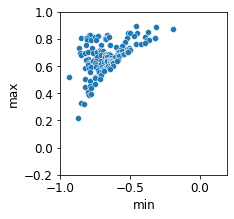

In [60]:
fig, ax = plt.subplots(figsize=[3, 3])
sns.scatterplot(data = exon_rhos.loc[exon_rhos.sort_values('r', ascending=False).index[:150].tolist()], 
                x='min', y='max', ax=ax)
lim = 1
ax.set_xlim(-lim, 0.2)
ax.set_ylim(-0.2, lim)

In [50]:
import gseapy as gp
from gseapy.plot import barplot

def pathway_df(gene_list):    
    pthw = gp.enrichr(gene_list=gene_list,
                         gene_sets=['GO_Biological_Process_2021'],
                         description='pathway',
                         cutoff = False).res2d

    pthw_plot = pthw[:10]
    pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])
    
    return pthw_plot

In [53]:
exon_path = pathway_df(exon_rhos.sort_values('r', ascending=False).index[:150].tolist())

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/gseapy/enrichr.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.results = self.results.append(res, ignore_index=True)
2023-05-15 14:46:12,156 Warning: No enrich terms using library GO_Biological_Process_2021 when cutoff = False
<ipython-input-50-b81eca27947c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pthw_plot['-log10(P-value)'] = -np.log10(pthw_plot['P-value'])


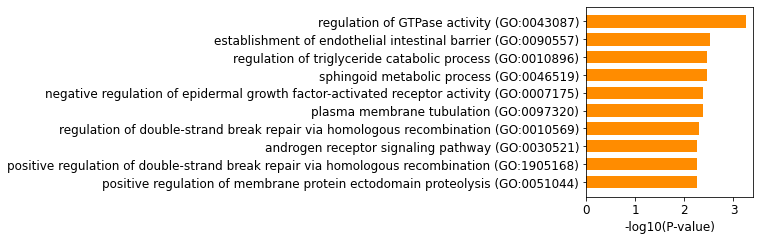

In [57]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=[3, 3.5])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 12

ax.barh(range(10), exon_path['-log10(P-value)'][::-1], height=0.7, color='darkorange')
ax.set_yticks(range(10))
ax.set_yticklabels(exon_path['Term'][::-1])

# ax.axhline(4.5, c='k', lw=1)
# handles = [Line2D([], [], lw=8, c='pink'),
#            Line2D([], [], lw=8, c='cornflowerblue')]
# ax.legend(handles=handles, labels=['+', '-'], title='Area vs. Exp', loc='best')

ax.set_xlabel('-log10(P-value)')
fig.savefig(save_figures2 + '150_genes_exon_pathway.pdf', dpi=150, bbox_inches='tight')

### channel 4 kdes

In [106]:
save_figures_C = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/channels_gene/'
corr_C = pd.read_csv(save_figures_C + 'spectra_gene_correlation.tsv', sep='\t', index_col=0).fillna(0)

{'fig': <Figure size 180x180 with 1 Axes>,
 'ax': <AxesSubplot: title={'center': 'Genes expressed by ≥10 cells'}, xlabel='$\\rho$ [343_451 vs. Exp]', ylabel='Density'>}

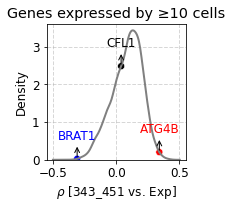

In [107]:
fea = '343_451'
genes = ['ATG4B', 'CFL1', 'BRAT1',]
colors = ['red', 'black', 'blue']
n = 10

kde_fea(corr_C, n, fea, genes, colors, path=save_figures_C)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


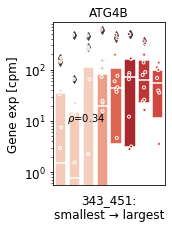

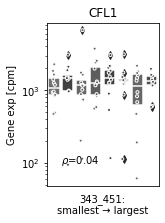

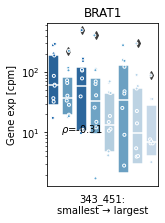

In [112]:
fea = '343_451' # '
genes = ['ATG4B', 'CFL1', 'BRAT1',] #  
cmaps = ['Reds', 'Greys', 'Blues'] # 
bin_n = 8

for gene, cmap in zip(genes, cmaps):
    rho = corr_C.loc[gene][fea]
    plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path=save_figures_C, rho=rho)